In [ ]:
""" VERSION 03 - GROUPING AUTHOR-1, AUTHOR-2 PAIRINGS, AND WEIGHT (COUNT) HOW MANY TIMES COAUTHORED TOGETHER
    28-APR-2021 Carol Paipa

SINA CO-AUTHOR NETWORK GRAPH ANALYSIS 

Code for generating Nodes/Edgest list for Co-Authors from Dimensions Dataset

Source data: Dimensions Published Papers for Profession Zhang between 2011 and 2021

1. Load in Dimensions Data Set
2. Split out Co-Authors per Paper
   - Assign Author ID for unique Author by Name
3. Generate Node list of unique Authors
4. Generate Edges list for Co-Author pairs - all Co-Authors are linked to each other
   - links between Papers will be based on unique Author names
"""
""" NEW FEATURES FOR MODEL WE COULD CONSIDER:
- coauthorship period - recent (0-2 yrs), medium (2-5 yrs), decade-10 (5-10 yrs), decade-20 (10-20 yrs), decade-20-plus (over 20 yrs)
- group size - solo (1), pair (2), group-small (3-5), group-med (5-10), group-large (10-20), group-xlarge (20-100), group-giant (100+)
- topic (of the paper) - limit to finite list in the data
- paper frequency of an author - the more times an author appears linked to papers, the more likely they are to colaborate
"""

In [2]:
# Load pandas
!pip install wordcloud
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns            
%matplotlib inline 
sns.set(color_codes=True)
import timeit

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

In [13]:
#-----------------------------------------------------------------------------
# Load in the Citations data
#-----------------------------------------------------------------------------
# doc_dv = 'Dimensions-Publication-2021-03-15_09-30-48.csv'
doc_dv = 'Dimensions-Publication-2021-04-18_09-17-17.csv'

data = pd.read_csv(doc_dv, skiprows=1, low_memory=False)
print(data.info())

# cleanup unwanted rows & columns
df_data = data.copy()
print('n-rows    = ', len(df_data),'(before filtering)')

# exclude rows where ID not begin with 'pub.'
df_data = df_data[df_data['Publication ID'].str.contains('pub.') == True]

# remove most columns exception for 'Publication ID', 'Cited references'
n = len(df_data.columns)
print('n-columns = ',n)
print('n-rows    = ', len(df_data),'(after filtering)','\n')

# only keep meaningful columns - not "unamed"
df_data.drop(df_data.iloc[:, 15:n], inplace = True, axis = 1) 
print(df_data.columns.tolist(),'\n')

# clean up rows where Times Cited is not a number
df_data_fix = df_data.copy()
df_data['len_cited'] = [len(str(x)) for x in df_data['Times cited']]
print(df_data.head(3))

print('len(df_data)',len(df_data))
df_data = df_data.dropna(subset=['Times cited'])
print('len(df_data)',len(df_data))

df_data = df_data[df_data['len_cited']<=3]
# print(df_data)

# convert Times cited to number
df_data['Fix'] = [int(x) for x in df_data['Times cited']]
columns=['Times cited']
df_data.drop(columns,axis=1,inplace=True)

# rename fixed column, back to Times cited
df_data = df_data.rename(columns={'Fix':'Times cited'})
print(df_data.info())                    

# Extract only the useful dimensions
df_data = df_data[['Publication ID','Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited','Cited references','PubYear']].copy()
df_data.columns = ['Publication ID','Title','Abstract','Authors','Authors Affiliations','Times Cited','Cited references','Pub Year']
df_data.head(3)

csv_file = 'Dimensions-Publication_small.csv'
df_data.to_csv(csv_file)
print('df_data                     ',df_data.shape)

#-----------------------------------------------------------------------------
# Extract out individual Authors, Affiliations, Cited references - from lists
#-----------------------------------------------------------------------------
# df_citat['Authors'][1]
# eg: 'Molin, Nicole L.; Molin, Clifford; Dalpatadu, Rohan J.; Singh, Ashok K.'

df_pub = df_data[['Publication ID','Authors','Authors Affiliations','Cited references','Times Cited','Pub Year']].copy()

df_pub.to_csv('df_published.csv')

# Replace NaN with a ';' - will delete these later stage
df_pub['Authors_2'] = df_pub['Authors'].fillna(';')
df_pub['Authors Affiliations_2'] = df_pub['Authors Affiliations'].fillna(';')
df_pub['Cited references_2'] = df_pub['Cited references'].fillna(';')
print('with additional fix columns ',df_pub.shape)
df_pub

# rename our fixed columns back to the original ones
df_pub = df_pub.drop(columns=(['Authors','Authors Affiliations','Cited references']))
df_pub.columns=(['Publication ID','Times Cited','Pub Year','Authors','Authors Affiliations','Cited references'])
print('after fix columns removed   ',df_pub.shape)

# Remove junk author to avoid count/sorting fail
pub_list = ['pub.1134802587','pub.1134588066']
df_pub[~df_pub['Publication ID'].isin(pub_list)]

# some test publications during development
pub_list_in = ['pub.1129598070','pub.1129601032','pub.1135906085','pub.1136271880']
#df_pub = df_pub[df_pub['Publication ID'].isin(pub_list_in)]

# extract sample rows for development only
sample_rows=5000
df_pub = df_pub[0:sample_rows]
print('test rows during development',df_pub.shape)

df_pub = df_pub.reset_index()
df_pub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454 entries, 0 to 2453
Data columns (total 15 columns):
Publication ID                                             2454 non-null object
DOI                                                        2414 non-null object
Title                                                      2454 non-null object
Abstract                                                   1907 non-null object
Source title/Anthology title                               2453 non-null object
PubYear                                                    2454 non-null int64
Volume                                                     2344 non-null object
Issue                                                      2062 non-null object
Pagination                                                 2299 non-null object
Authors                                                    2454 non-null object
Authors Affiliations - Name of Research organization       1969 non-null object
Authors Affili

,index,Publication ID,Times Cited,Pub Year,Authors,Authors Affiliations,Cited references
0,0,pub.1135650611,0,2021,"Suel, Esra; Bhatt, Samir; Brauer, Michael; Fla...",Imperial College London; ETH Zurich; Universit...,"[Yue, Jun; Zhao, Wenzhi; Mao, Shanjun; Liu, Hu..."
1,1,pub.1136928512,0,2021,"Anenberg, Susan; Mohegh, Arash; Goldberg, Dani...",George Washington University; University of Br...,"[Perez, Laura; Lurmann, Fred; Wilson, John; Pa..."
2,2,pub.1136892376,0,2021,"Stieb, David M; Evans, Greg J; To, Teresa M; L...",Health Canada; University of Ottawa; Universit...,;
3,3,pub.1136866794,0,2021,"Bowe, Benjamin; Gibson, Andrew K.; Xie, Yan; Y...",Saint Louis University; Washington University ...,"[Crouse, Dan L.; Philip, Sajeev; van Donkelaar..."
4,4,pub.1133731628,1,2021,"Abera, Asmamaw; Friberg, Johan; Isaxon, Christ...",Addis Ababa University; Lund University; Unive...,"[Rehfuess, E A; Tzala, L; Best, N; Briggs, D J..."
...,...,...,...,...,...,...,...
2429,2449,pub.1030592224,0,1983,"Pope, C. Arden; Heady, Earl O.",Texas A&M University,;
2430,2450,pub.1060056001,1,1983,"KREWSKI, D.; CRUMP, K.S.; FARMER, J.; GAYLOR, ...",;,;
2431,2451,pub.1069862033,0,1982,"Iachan, Ronaldo; Krewski, D.; Platek, R.; Rao,...",;,;
2432,2452,pub.1064407837,160,1981,"Krewski, D.; Rao, J. N. K.",;,;


## Create wide-column table with each individual author per column (col heading is author-index)
### Each Paper pub.ID is one row, each column to the right of "# Authors" is one author

In [14]:
#----------------------------------------------------
# Extract individual strings from list - Authors
#----------------------------------------------------
df_pub['Authors_Split'] = [list(x.split('; ')) for x in df_pub['Authors']]
df_pub.head()

# df_test['Authors_Split'].iloc[2]
df_split = df_pub[['index','Publication ID','Times Cited','Pub Year','Authors_Split']].copy()
df_split

# how many co-authors for each paper
df_split['# Authors'] = [len(x) for x in df_split['Authors_Split']]
df_split.sort_values('# Authors', ascending=False)
df_split

# Dataframe just of Pub-ID with Index 0-N rows NOTE: if adding new columns before # Authors - add +1 (per new column) to col_index
col_index = 6
df_paper = pd.DataFrame(df_split.iloc[:,:col_index])   #.values.tolist())  #.reset_index()
# temp name for index column
df_paper['index_pub'] = df_paper['index']
df_paper = df_paper[['index','index_pub','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors']]
df_paper

# Dataframe just of Authors but converted to columns (across)
df_auth = df_split[['index','Authors_Split']].copy()
df_auth_cols = df_auth.iloc[:,1].apply(pd.Series).reset_index()  
df_auth_cols

# Concat (join) dataframes based on Index (hopefully they match original Pub-ID and Author rows)
df_new = pd.concat([df_paper, df_auth_cols], axis=1)
df_new = df_new.fillna('')

# remove both index columns
df_new.drop(df_new.iloc[:,:1], inplace = True, axis = 1)
df_new = df_new.rename(columns={'index_pub':'index'})
df_new

,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,0,1,2,3,...,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra","Bhatt, Samir","Brauer, Michael","Flaxman, Seth",...,,,,,,,,,,
1,1,pub.1136928512,0,2021,"[Anenberg, Susan, Mohegh, Arash, Goldberg, Dan...",8,"Anenberg, Susan","Mohegh, Arash","Goldberg, Daniel L.","Brauer, Michael",...,,,,,,,,,,
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M","Evans, Greg J","To, Teresa M","Lakey, Pascale S J",...,,,,,,,,,,
3,3,pub.1136866794,0,2021,"[Bowe, Benjamin, Gibson, Andrew K., Xie, Yan, ...",7,"Bowe, Benjamin","Gibson, Andrew K.","Xie, Yan","Yan, Yan",...,,,,,,,,,,
4,4,pub.1133731628,1,2021,"[Abera, Asmamaw, Friberg, Johan, Isaxon, Chris...",8,"Abera, Asmamaw","Friberg, Johan","Isaxon, Christina","Jerrett, Michael",...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,2449,pub.1030592224,0,1983,"[Pope, C. Arden, Heady, Earl O.]",2,"Pope, C. Arden","Heady, Earl O.",,,...,,,,,,,,,,
2430,2450,pub.1060056001,1,1983,"[KREWSKI, D., CRUMP, K.S., FARMER, J., GAYLOR,...",9,"KREWSKI, D.","CRUMP, K.S.","FARMER, J.","GAYLOR, D.W.",...,,,,,,,,,,
2431,2451,pub.1069862033,0,1982,"[Iachan, Ronaldo, Krewski, D., Platek, R., Rao...",4,"Iachan, Ronaldo","Krewski, D.","Platek, R.","Rao, J. N. K.",...,,,,,,,,,,
2432,2452,pub.1064407837,160,1981,"[Krewski, D., Rao, J. N. K.]",2,"Krewski, D.","Rao, J. N. K.",,,...,,,,,,,,,,


## Create long-row table now with each Paper + Author as one row
#### - one row is paper pub.id + one author
#### - papers with multiple co-authors will appear multiple (row) times
eg: paper pub.1109780440 has 1212 authors => so will results in 1212 rows

In [29]:
#------------------------------------------------------
# iterate across all author columns, append them after each other, final concat for all appended dataframes
#------------------------------------------------------
# create Pub-ID column name so can link back to original data
col_list = list(df_new.columns.values)
col_list

print('authors col_list = ',col_list[5],'-',col_list[len(col_list)-1])
col_end = col_list[len(col_list)-1]

# iterate across all author columns
all_auth = []
new_list = ['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors','Author']
for col in col_list[col_index:]:
    df_app = []
    df_app = df_new[['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors',col]].copy()
    df_app.columns = new_list
    all_auth.append(df_app)

# concatenated all appended Author (wide) columns into 1 single column
df_pub_auth = pd.concat(all_auth)
print('len pub-auth all rows         ',df_pub_auth.shape)

# remove rows with blank Authors
df_pub_auth = df_pub_auth[df_pub_auth['Author']!='']  
df_pub_auth = df_pub_auth[df_pub_auth['Author']!=';']  
print('len pub-auth del blank Authors',df_pub_auth.shape)

# save output Published Papers - each Author linked to paper
df_pub_auth.to_csv('df_pub_authors.csv')
df_pub_auth

authors col_list =  # Authors - 1211
len pub-auth all rows          (2950008, 7)
len pub-auth del blank Authors (37052, 7)


,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra"
1,1,pub.1136928512,0,2021,"[Anenberg, Susan, Mohegh, Arash, Goldberg, Dan...",8,"Anenberg, Susan"
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M"
3,3,pub.1136866794,0,2021,"[Bowe, Benjamin, Gibson, Andrew K., Xie, Yan, ...",7,"Bowe, Benjamin"
4,4,pub.1133731628,1,2021,"[Abera, Asmamaw, Friberg, Johan, Isaxon, Chris...",8,"Abera, Asmamaw"
...,...,...,...,...,...,...,...
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zoeckler, Leo"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zucker, Inbar"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Zuhlke, Liesel Joanna J"
375,376,pub.1109780440,159,2018,"[Collaborators, GBD 2017 SDG, Lozano, Rafael, ...",1212,"Lim, Stephen S"


### CREATE "Author" nodes - assume Author with same name is the same Author - may not be true in real life

#### - node_id will be unique per author name, and becomes the author-index later on
#### - size_author is the number of papers that authors name can be linked to
#### Some authors have full names, or lastname + initial - but for now, we will treat them as 2 authors


In [36]:
#-----------------------------------------------------------
# create Author nodes - assume Author with same name
# is the same Author - may not be true in real life
#-----------------------------------------------------------

df_node_author = df_pub_auth.copy()
df_node_author = df_node_author[['index','Author']].groupby('Author').count().reset_index().reset_index()
df_node_author.columns=(['index_author','Author','Author Count Times'])
df_node_author

# combine Published-Author + Author-ID to link Paper-ID and Author-ID
df_pub_auth_count = df_pub_auth.join(df_node_author.set_index('Author'), on='Author')
df_pub_auth_count

#-------------------------------------------------------
# finish creating nodes for each Author (unique by name)
df_node_author['node_group']='author'
df_node_author.columns=(['node_id','node_name','size_author','node_group'])
df_node_author

#-------------------------------------------------------
# check rows are the same - start of Pub list, end of Author list - matching above lists
nodes = df_node_author[['node_id','node_name','node_group','size_author']]
nodes.to_csv('df_pub_auth_nodes.csv')

nodes.sort_values('size_author', ascending=False).head(5)

,node_id,node_name,node_group,size_author
6146,6146,"Krewski, Daniel",author,419
1524,1524,"Brauer, Michael",author,385
5410,5410,"Jerrett, Michael",author,307
7376,7376,"Martin, Randall V.",author,167
1610,1610,"Brook, Jeffrey R.",author,165


### Top 10 Authors linked to published papers - these are prolific researchers

#### Could be a feature - the more times an author is linked to a new paper - the more likely they are to colaborate

In [23]:
#df_p = pd.DataFrame(df_auth.pivot_table(index=['Author'], aggfunc='size')).reset_index().reset_index()
#df_p.columns = ['index','Author','count']

x_lab = 'node_name'
y_lab = 'size_author'

# set limit to show on x-axis
size_min = 45
clrs = ['#3498db'] 

df_p = nodes.copy()
df_p = df_p[df_p[y_lab]>=size_min].sort_values('size_author', ascending=False)
print("Top 10 mentioned authors")
print('df_p:',df_p.sort_values('size_author', ascending=False).head(10))

Top 10 mentioned authors
df_p:        node_id             node_name node_group  size_author
6146      6146       Krewski, Daniel     author          419
1524      1524       Brauer, Michael     author          385
5410      5410      Jerrett, Michael     author          307
7376      7376    Martin, Randall V.     author          167
1610      1610     Brook, Jeffrey R.     author          165
13028    13028  van Donkelaar, Aaron     author          161
5162      5162         Hystad, Perry     author          144
1718      1718   Burnett, Richard T.     author          138
4198      4198     Goldberg, Mark S.     author          126
11917    11917   Villeneuve, Paul J.     author          119


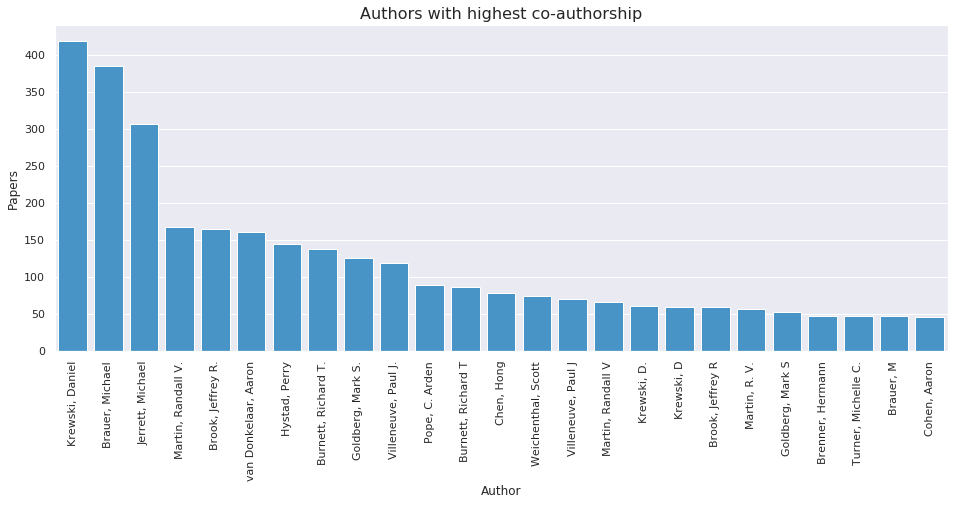

In [7]:
# Visualise number of papers an author is linked to
#-----------------------------------------------------------------

fig = plt.figure(figsize=(16, 6))   
ax = sns.barplot(data=df_p, x=x_lab, y=y_lab, order=df_p[x_lab], palette=sns.color_palette(clrs, 10))

#ax.set(ylim=(0, 125))
ax.set_title('Authors with highest co-authorship', fontsize=16)
plt.xlabel('Author')
plt.ylabel('Papers')
plt.rcParams["figure.figsize"] = (10,3)
plt.xticks(rotation='vertical')
#plt.xticks([])
#plt.yticks([])
plt.show();

### Which papers have the most number of co-authors
#### - 2 papers over 1000 co-authors
#### - 30 approx with over 200 co-authors
These co-author sizes add great complexity to our data model

In [24]:
#-----------------------------------------------------------------
# Visualise number of co-authors per paper - limit number of papers for graph
#-----------------------------------------------------------------

#df_p = pd.DataFrame(df_auth.pivot_table(index=['Author'], aggfunc='size')).reset_index().reset_index()
#df_p.columns = ['index','Author','count']

x_lab = 'Publication ID'
y_lab = '# Authors'
# set limit to show on x-axis
size_min = 100
clrs = ['#3498db'] 

df_pa = df_pub_auth[['Publication ID','# Authors']].copy()
df_pa = df_pa[df_pa[y_lab]>=size_min].groupby(['Publication ID','# Authors']).count().reset_index().sort_values('# Authors', ascending=False)

print('Top 10 papers with number of authors (total papers):',len(df_pa))
df_pa.sort_values('# Authors', ascending=False).head(5)

Top 10 papers with number of authors (total papers): 56


,Publication ID,# Authors
36,pub.1109780440,1212
51,pub.1131781786,1031
50,pub.1131774541,941
3,pub.1007496904,909
53,pub.1131794493,866


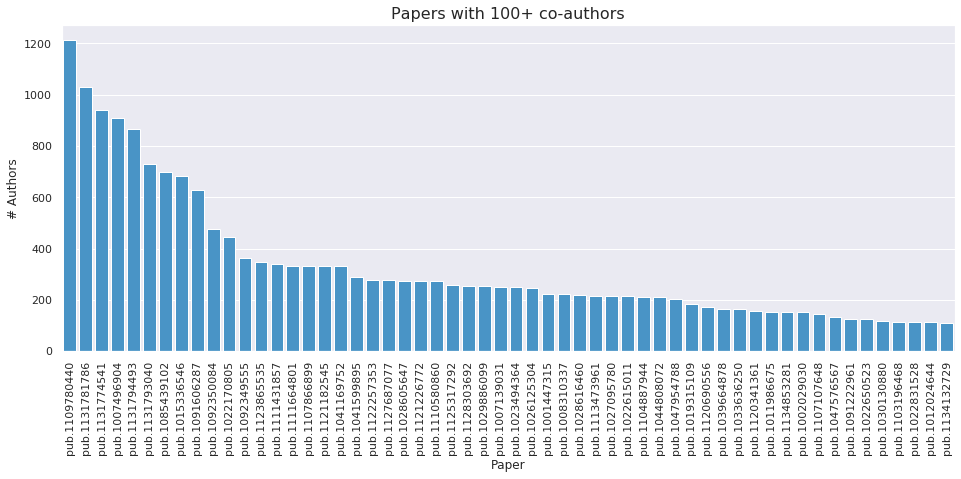

In [64]:
fig = plt.figure(figsize=(16, 6))   
ax = sns.barplot(data=df_pa, x=x_lab, y=y_lab, order=df_pa[x_lab], palette=sns.color_palette(clrs, 10))

#ax.set(ylim=(0, 125))
ax.set_title('Papers with 100+ co-authors', fontsize=16)
plt.xlabel('Paper')
plt.ylabel('# Authors')
plt.rcParams["figure.figsize"] = (10,3)
plt.xticks(rotation='vertical')
#plt.xticks([])
#plt.yticks([])
plt.show();

## Create Co-Author Relationships for Network Graph
Each Co-Author of a Paper is linked to each other - like a Clique (sub-network)

In [38]:
 """ BACKUP COPY IF WE NEED TO RE-RUN BELOW """
df_pub_auth_bak = df_pub_auth_count.copy()
# 37,052 unique authors 
len(df_pub_auth_bak)

37052

In [51]:
#------------------------------------------------------------
# LIMIT PAPERS CO-AUTHOR SIZE - JUST DURING DEVELOPMENT
# Number of papers with max 5 authors: 3541  
# (max 10 = 10624 rows, max 100 = 18640 rows)
#------------------------------------------------------------
max_coauthor = 10

df_pub_auth_subset = df_pub_auth_count[df_pub_auth_count['# Authors']<=max_coauthor].copy()

print(f'\nNumber of papers with max {max_coauthor} authors:',len(df_pub_auth_subset),'\n')

# data for Published Paper ID linked to Co-Author ID's
df_pub_auth_subset


Number of papers with max 10 authors: 10624 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Count Times
0,0,pub.1135650611,0,2021,"[Suel, Esra, Bhatt, Samir, Brauer, Michael, Fl...",5,"Suel, Esra",11038,1
1,1,pub.1136928512,0,2021,"[Anenberg, Susan, Mohegh, Arash, Goldberg, Dan...",8,"Anenberg, Susan",485,1
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M",10944,14
3,3,pub.1136866794,0,2021,"[Bowe, Benjamin, Gibson, Andrew K., Xie, Yan, ...",7,"Bowe, Benjamin",1466,1
4,4,pub.1133731628,1,2021,"[Abera, Asmamaw, Friberg, Johan, Isaxon, Chris...",8,"Abera, Asmamaw",66,1
...,...,...,...,...,...,...,...,...,...
2096,2113,pub.1047676514,45,2001,"[Luginaah, Isaac, Jerrett, Michael, Elliott, S...",10,"Giovis, Chris",4131,4
2110,2127,pub.1074781606,58,2000,"[Goldberg, M S, Bailar, J C, Burnett, R T, Bro...",10,"Valois, M F",11774,4
2144,2161,pub.1026196349,457,1999,"[Pope, C.Arden, Verrier, Richard L., Lovett, E...",10,"Dockery, Douglas W.",3027,16
2208,2225,pub.1019314222,3,1998,"[Lippmann, Morton, Bachmann, John D., Cassee, ...",10,"Wilson, William E.",12391,4


## Check one author - by name - all papers linked to this author name
#### Within or max numer of co-authors per paper
#### During testing only

In [52]:
""" VALIDATING DATA ONLY - NOT FOR FULL PROCESS """

""" change this author name, if you want to view a different authors list of papers """
# drill down into selected author - by name
select_author_name = 'Pope, C. Arden'

# get published papers "index" linked to an author "index_author"
pub_list = df_pub_auth[df_pub_auth['Author']==select_author_name]['index'].unique().tolist()

# author name from node file (so only 1 instance)
print('Published papers linked to -',nodes[nodes['node_name']==select_author_name]['node_name'],'\n')

# show all papers linked to selected author
df_pub_auth[df_pub_auth['Author']==select_author_name].head(10)

Published papers linked to - 9201    Pope, C. Arden
Name: node_name, dtype: object 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author
178,178,pub.1123233429,1,2019,"[Pope, C. Arden, Bhatnagar, Aruni]",2,"Pope, C. Arden"
296,296,pub.1114029795,2,2019,"[Pope, C. Arden]",1,"Pope, C. Arden"
394,395,pub.1122887813,0,2018,"[Pope, C. Arden]",1,"Pope, C. Arden"
519,520,pub.1099703196,32,2017,"[Pope, C. Arden, Ezzati, Majid, Cannon, John B...",6,"Pope, C. Arden"
536,537,pub.1099674738,7,2017,"[Pope, C. Arden, Krewski, Daniel, Gapstur, Sus...",6,"Pope, C. Arden"
816,821,pub.1012746265,7,2015,"[Pope, C. Arden, Ezzati, Majid, Dockery, Dougl...",3,"Pope, C. Arden"
912,919,pub.1008182883,72,2014,"[Pope, C. Arden, Cropper, Maureen, Coggins, Ja...",4,"Pope, C. Arden"
1099,1106,pub.1033097791,58,2013,"[Pope, C. Arden, Dockery, Douglas W.]",2,"Pope, C. Arden"
1136,1143,pub.1044763881,29,2013,"[Pope, C. Arden, Ezzati, Majid, Dockery, Dougl...",3,"Pope, C. Arden"
1166,1177,pub.1047886172,0,2012,"[Pope, C. Arden, Burnett, Richard, Turner, Mic...",7,"Pope, C. Arden"


## Check one author - by Index No - all papers linked to this author index
#### Within or max numer of co-authors per paper
#### During testing only

In [53]:
""" VALIDATING DATA ONLY - NOT FOR FULL PROCESS """

""" change this index number, if you want to view a different authors list of papers """
# drill down into selected author - by index number
select_author_index = 10944    

# get published papers "index" linked to an author "index_author"
pub_list = df_pub_auth_count[df_pub_auth_count['index_author']==select_author_index]['index'].unique().tolist()

# author name from node file (so only 1 instance)
print('Published papers linked to -',nodes[nodes['node_id']==select_author_index]['node_name'],'\n')

# show all papers linked to selected author
df_pub_auth_count[df_pub_auth_count['index_author']==select_author_index]

Published papers linked to - 10944    Stieb, David M
Name: node_name, dtype: object 



,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Count Times
2,2,pub.1136892376,0,2021,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",10,"Stieb, David M",10944,14
43,43,pub.1134078292,0,2020,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",5,"Stieb, David M",10944,14
88,88,pub.1130332642,8,2020,"[Stieb, David M, Evans, Greg J, To, Teresa M, ...",5,"Stieb, David M",10944,14
1668,1682,pub.1011333405,14,2007,"[Stieb, David M, Evans, Gregory J, Sabaliauska...",8,"Stieb, David M",10944,14
1849,1864,pub.1036690893,37,2005,"[Stieb, David M, Doiron, Marc Smith, Blagden, ...",4,"Stieb, David M",10944,14
1928,1943,pub.1001722369,0,2004,"[Stieb, David M, Krupnick, Alan J, Adamowicz, ...",6,"Stieb, David M",10944,14
455,456,pub.1105982177,26,2018,"[Lavigne, Éric, Burnett, Richard T, Stieb, Dav...",8,"Stieb, David M",10944,14
1968,1984,pub.1031058114,177,2003,"[Gilbert, Nicolas L, Woodhouse, Sandy, Stieb, ...",4,"Stieb, David M",10944,14
18,18,pub.1135997077,0,2021,"[Lavigne, Éric, Talarico, Robert, van Donkelaa...",10,"Stieb, David M",10944,14
1029,1036,pub.1031124279,25,2013,"[Chen, Li, Villeneuve, Paul J, Rowe, Brian H, ...",5,"Stieb, David M",10944,14


## CREATE AUTHOR-PAIRS for each published paper
### A1, A2 combination
#### Using sample authors during development until logic is confirmed

In [54]:
# 3541 rows where max 5 co-authors on a paper
len(df_pub_auth_subset)

# 1528 unique authors in df_pub_auth_subset step
len(df_pub_auth_subset['index_author'].unique().tolist())

# create list of unqiue authors in "max # co-authors" sample 
sample_author = df_pub_auth_subset['index_author'].unique().tolist()
print(f'Sample of unique authors in max ({max_coauthor}) co-author sample (total {len(sample_author)} authors)\n',sample_author[0:50])

Sample of unique authors in max (10) co-author sample (total 4262 authors)
 [11038, 485, 10944, 1466, 66, 10803, 9822, 11162, 12708, 6821, 10505, 5018, 10371, 5101, 6469, 1109, 3916, 6862, 8482, 4197, 4368, 1524, 2513, 11916, 1609, 2387, 2945, 8690, 4586, 793, 12151, 7507, 12364, 6838, 9918, 1248, 9633, 12872, 12481, 2027, 5779, 1798, 12120, 12379, 1995, 2595, 4575, 9199, 2474, 8025]


In [55]:
#--------------------------------------------------------------------------
# following code inspired by DVN week 8 lab - Song Similarity Network Graph
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

""" drill down into selected author - while building graph so not too many to blow out memory """
""" SAMPLE DURING DEVELOPMENT """
#select_author_index = [10944,1717]
#select_author_index = [6146,2161]
select_author_index = sample_author

# Get all unique Publication ID's
# pub_list = df_pub_auth_subset['index'].unique().tolist()
pub_list = df_pub_auth_subset[df_pub_auth_subset['index_author'].isin(select_author_index)]['index'].unique().tolist()
#print('Publication index list ',pub_list,'\n')
print('Published papers (count)        :',len(pub_list), '  <= approx. number of columns wide in modelling data')

# pub_list[0:500] = Total time is : 12.44 seconds / 0.21 minutes
# pub_list = pub_list[0:500]
# print('# of Publications (sample) ',len(pub_list),'\n')

# Subsetting
def subtable(df, productName):
    return (df[(df['index'] == productName)])

all_pairs = []
df_pairs = []

# iterate through list of published papers + each co-author
i = 0
for pub in pub_list:
    auth_pairs = []
    df_subset = subtable(df_pub_auth_subset.copy(), pub)
    # create indicies for each co-author in paper
    auth_indicies = df_subset['index_author'].values.tolist()
    # link all co-author indicies as pairs to each other
    auth_pairs = pd.DataFrame(list(itertools.combinations(auth_indicies, 2)))
    #print('Publication ID',pub,', co-author pairs =', len(auth_pairs))  #, '\n', auth_pairs,'\n')
    all_pairs.append(auth_pairs)
    df_pairs = pd.concat(all_pairs)
    i += 1

print('Iterations for auth-pairs       :', i)

# EDGE WEIGHT is number of papers author-pairs are linked to, eg: A1,A2 weight = 3, will be 3 rows, means 3 papers
# auth_pairs rows repeat each time per paper they are co-authors in
# 6146	2161
# 6146	2161
# 6146	2161
# This pair - edge weight is 3

df_pairs = df_pairs.groupby([0,1]).size()\
    .sort_values(ascending=False)\
    .reset_index(name='weight')\
    .drop_duplicates(subset=1)

# print('Final pairs co-authors for each Published Paper')
df_pairs.columns = ['author-1','author-2','weight']

# create auth-pair "tuple" (just a string for now)
df_pairs['auth-pair'] = df_pairs['author-1'].astype(str).str.cat(df_pairs['author-2'].astype(str), sep=',')

# JUST FOR TESTING - BASED ON ORIGINAL 2 AUTH-PAIRS [10944,1717]
pair_list = df_pairs['author-1'].unique().tolist() + df_pairs['author-2'].unique().tolist()
pair_list = pd.DataFrame(sample_author)[0].unique().tolist()

print("Number of auth-pair rows        :", len(df_pairs))
print("Unique authors in auth-pair list:", len(pair_list))

if (timeit.default_timer() - starttime) > 60:
    print('Total time is                   : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

# pairing only done once - possibly - still need to check index pairs
# 1171 pair rows in "max 5 coauthors" sample data
# df_pairs[(df_pairs['author-1'].isin(select_author_index)) | (df_pairs['author-2'].isin(select_author_index))] #.head(10)
# 6146, 2161
# df_pairs[(df_pairs['author-1']==6146) & (df_pairs['author-2']==2161)]

print('    sample pairing of co-authors, weight is the number of papers they co-author together')
df_pairs.head(10)

Published papers (count) : 1908   *will be number of columns wide in modelling data
Iterations for auth-pairs: 1908
Pairs in auth-pair list  : 4262
Total time is : 82.50 seconds / 1.37 minutes
    sample pairing of co-authors, weight is the number of papers they co-author together


,author-1,author-2,weight,auth-pair
0,13028,7376,25,"13028,7376"
1,2161,6146,22,"2161,6146"
3,11205,1524,21,"11205,1524"
4,6146,11700,19,"6146,11700"
5,6146,12231,18,"6146,12231"
7,12979,5410,17,"12979,5410"
8,7376,13028,17,"7376,13028"
9,4198,11777,16,"4198,11777"
11,13028,7375,15,"13028,7375"
13,1547,11278,15,"1547,11278"


## FIND OUT how many times author-pairs are linked to a paper

In [450]:
# sample of one author index - all linked author-2
len(df_pairs[df_pairs['author-1']==6146]['author-2'])
len(df_pairs[df_pairs['author-1']==6146]['author-2'].unique().tolist())
df_pairs[df_pairs['author-1']==6146]

,author-1,author-2,weight,auth-pair
0,6146,11700,18,"6146,11700"
7,6146,2161,8,"6146,2161"
20,6146,1717,4,"6146,1717"
35,6146,9599,4,"6146,9599"
38,6146,453,4,"6146,453"
66,6146,12904,3,"6146,12904"
69,6146,1720,3,"6146,1720"
73,6146,1718,2,"6146,1718"
78,6146,3680,2,"6146,3680"
81,6146,4055,2,"6146,4055"


In [58]:
# FIND HOW MANY TIMES - PAIR (A1, A2) & (A2, A1) are linked, ie: multiple paper co-authorship

# copy of subset data
df_pub_rep = df_pub_auth_subset[['index','Publication ID','index_author','Author']].copy()
len(df_pub_rep)

# only auth-pairs in sample
df_pub_rep_pub = df_pub_rep[df_pub_rep['index_author'].isin(sample_author)].copy()
len(df_pub_rep_pub)

# show all publications where A1 or A2 are linked - some A1 & A2 are not linked through these papers
print('      All papers authors are linked to - regardless of A1, A2 links')
df_pub_rep_pub.sort_values('Publication ID')

      All papers authors are linked to - regardless of A1, A2 links


,index,Publication ID,index_author,Author
1985,2001,pub.1000009542,12037,"Walmsley, John L"
1985,2001,pub.1000009542,1609,"Brook, Jeffrey R"
1985,2001,pub.1000009542,11735,"Urquizo, Natty"
1985,2001,pub.1000009542,1726,"Burrows, William R"
1972,1988,pub.1000018034,12812,"Zhang, Leiming"
...,...,...,...,...
1,1,pub.1136928512,4188,"Goldberg, Daniel L."
1,1,pub.1136928512,5162,"Hystad, Perry"
1,1,pub.1136928512,12478,"Wozniak, Sarah"
1,1,pub.1136928512,1524,"Brauer, Michael"


## Only publications where both authors are on that paper

In [60]:
# only pulications where both authors are on that paper
df_pub_rep_pair = df_pub_rep_pub.groupby('Publication ID').count().reset_index()

# df_pub_rep_pair = df_pub_rep_pair[df_pub_rep_pair['index']>1].iloc[:,:1]
# print(df_pub_rep_pair)

auth_pair_count_papers = len(df_pub_rep_pair)
print('Total papers auth-pair are linked:', auth_pair_count_papers)

df_pub_rep_pair = df_pub_rep_pair['Publication ID'].unique().tolist()
print('len(df_pub_rep_pair)             :', len(df_pub_rep_pair), '\nSample only:\n', df_pub_rep_pair[0:20])

Total papers auth-pair are linked: 1908
len(df_pub_rep_pair)             : 1908 
Sample only:
 ['pub.1000009542', 'pub.1000018034', 'pub.1000022383', 'pub.1000102971', 'pub.1000145753', 'pub.1000159198', 'pub.1000186965', 'pub.1000247375', 'pub.1000302790', 'pub.1000428611', 'pub.1000478761', 'pub.1000602843', 'pub.1000651854', 'pub.1000671970', 'pub.1000722795', 'pub.1000783026', 'pub.1000863842', 'pub.1000869710', 'pub.1000882121', 'pub.1000896024']


## Generate correct edge weight
### Actual number of papers 2 authors have colaborated on

In [61]:
starttime = timeit.default_timer()

# df_iter = df_pairs.head(5)

df_pairs_fix = pd.DataFrame()

# auth_select = [6852,10464]
for index, row in df_pairs.iterrows():
    #print('Iterate:',row['author-1'], ',', row['author-2'], '- weight:', row['weight'])
    auth_select = (row['author-1'], row['author-2'])
    
    # split published papers with A1 & A2 into 2 data frames - then join into 1 row
    df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[0])]
    df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','index_author']]
    #print(df_pub_rep_1a)

    df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[1])]
    df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','index_author']]
    #print(df_pub_rep_1b)

    df_pub_rep_ab = df_pub_rep_1a.join(df_pub_rep_1b, how='inner', rsuffix="_y").drop(columns=['index_y','Publication ID_y'])
    df_pub_rep_ab.columns = ('index','Publication ID','author-1','author-2')

    # create auth-pair
    df_pub_rep_ab['auth-pair'] = df_pub_rep_ab['author-1'].astype(str).str.cat(df_pub_rep_ab['author-2'].astype(str), sep=',')
    df_pub_rep_ab['count'] = 1

    #print(f"      Actual paper colaborations for ({row['author-1']}, {row['author-2']}) pair, papers =",len(df_pub_rep_ab))
    #print(df_pub_rep_ab)
    df_pair_count = df_pub_rep_ab.groupby(['author-1','author-2']).agg({'index':'count'}).reset_index()
    df_pair_count.columns = ['author-1','author-2','weight']
    df_pair_count['auth-pair-str'] = df_pair_count['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str), sep=',') 
    # create list of author-1, author-2 - we need list, not string, for indexing next step
    df_pair_count['auth-pair'] = [[df_pair_count['author-1'][0],df_pair_count['author-2'][0]]]
   
    df_pairs_fix = pd.concat([df_pairs_fix, df_pair_count], ignore_index=True)  

    
if (timeit.default_timer() - starttime) > 0:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

print('\nAuthor pairs weight correct to actual # papers co-authored')
df_pairs_fix


Total time is : 52.60 seconds / 0.88 minutes

Author pairs weight correct to actual # papers co-authored


,author-1,author-2,weight,auth-pair-str,auth-pair
0,13028,7376,42,"13028,7376","[13028, 7376]"
1,2161,6146,36,"2161,6146","[2161, 6146]"
2,11205,1524,23,"11205,1524","[11205, 1524]"
3,6146,11700,34,"6146,11700","[6146, 11700]"
4,6146,12231,27,"6146,12231","[6146, 12231]"
...,...,...,...,...,...
3703,7555,3616,1,"7555,3616","[7555, 3616]"
3704,7536,7131,1,"7536,7131","[7536, 7131]"
3705,7544,12423,1,"7544,12423","[7544, 12423]"
3706,7543,12422,1,"7543,12422","[7543, 12422]"


In [45]:
""" TESTING CODE ONLY - NO LONGER REQUIRED - DEF FUNCTION ABOVE STEP """
if 1==2:
    select_author_index=[6146 , 11700]
    df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author'].isin(auth_select))].to_csv('df_comments.csv')

    # split published papers with A1 & A2 into 2 data frames - then join into 1 row
    df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==select_author_index[0])]
    df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','index_author']]
    df_pub_rep_1a

    df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==select_author_index[1])]
    df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','index_author']]
    df_pub_rep_1b

    df_pub_rep_ab = df_pub_rep_1a.join(df_pub_rep_1b, how='inner', rsuffix="_y").drop(columns=['index_y','Publication ID_y'])
    df_pub_rep_ab.columns = ('index','Publication ID','author-1','author-2')

    # create auth-pair
    df_pub_rep_ab['auth-pair'] = df_pub_rep_ab['author-1'].astype(str).str.cat(df_pub_rep_ab['author-2'].astype(str), sep=',')
    df_pub_rep_ab['count'] = 1

    print('      Actual paper colaborations for A1, A2 pair =', len(df_pub_rep_ab),'papers')
    print(len(df_pub_rep_ab))
    df_pub_rep_ab.head(5)

## Split published papers with A1 & A2 into 2 data frames - then join into 1 row

In [66]:
# split published papers with A1 & A2 into 2 data frames - then join into 1 row
def papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_index, print_idx):
    df_pub_rep_A1_A2 = pd.DataFrame()
    print('')
    i = 0
    for idx in select_author_index:
        i += 1
        if print_idx==True:
            print(f'idx-{i}: {idx}')
        df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[0])]
        df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','index_author']]
        #print('df_pub_rep_1a:',df_pub_rep_1a)

        df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[1])]
        df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','index_author']]
        #print('df_pub_rep_1b:',df_pub_rep_1b)

        df_pub_rep_ab = df_pub_rep_1a.join(df_pub_rep_1b, how='inner', rsuffix="_y").drop(columns=['index_y','Publication ID_y'])
        df_pub_rep_ab.columns = ('index','Publication ID','author-1','author-2')

        # create auth-pair  df_pair_count['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str), sep=',') 
        #df_pub_rep_ab['auth-pair'] = df_pub_rep_ab['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str), sep=',') 
        df_pub_rep_ab['count'] = 1
        df_pub_rep_A1_A2 = pd.concat([df_pub_rep_A1_A2, df_pub_rep_ab], ignore_index=True)  
        #print(df_pub_rep_A1_A2)
        
    return df_pub_rep_A1_A2

#----------------------------------------
select_author_pair=[ [6146,11700],[6146,2161] ]
#select_author_pair=[ [6146,11700],[1726,1609],[1726,11735],[1726,12037],[885,307] ]
#select_author_pair=[ [6146,11700], [6619,6146], [10115,1524] ]

#print('select_author_index:',select_author_index,'# pairs:',len(select_author_pair[0]),'\n')
print('\nTotal author-pairs          :',len(select_author_pair),'\nselect_author_index (sample):',select_author_pair[0:5])

# create list of papers that A1, A2 have colaborated on
df_pub_rep_ab = papers_A1_A2(df_pub_rep_pub,df_pub_rep_pair,select_author_pair, print_idx=True)

print('\n      Example authors: actual paper colaborations for A1, A2 pair =', len(df_pub_rep_ab),'papers')
df_pub_rep_ab


Total author-pairs          : 2 
select_author_index (sample): [[6146, 11700], [6146, 2161]]

idx-1: [6146, 11700]
idx-2: [6146, 2161]

      Example authors: actual paper colaborations for A1, A2 pair = 70 papers


,index,Publication ID,author-1,author-2,count
0,1839,pub.1100761043,6146,11700,1
1,1446,pub.1067488638,6146,11700,1
2,1447,pub.1067488637,6146,11700,1
3,1450,pub.1067488634,6146,11700,1
4,1451,pub.1067488633,6146,11700,1
...,...,...,...,...,...
65,2015,pub.1033532113,6146,2161,1
66,2061,pub.1064737676,6146,2161,1
67,1911,pub.1017112085,6146,2161,1
68,2012,pub.1044459104,6146,2161,1


In [67]:
#---------------------------------------------------------
# RUN FOR ALL AUTH-PAIRS & LINKED PAPERS
#---------------------------------------------------------
starttime = timeit.default_timer()

# rerun previous step but for all author pairs, not just sample
select_author_pair = df_pairs_fix['auth-pair'].tolist()

# NOTE: select_author_index must be a list of [A1,A2] lists
# ie:   [[6146, 11700], [6619, 6146], [10115, 1524], [6146, 2161], [9201, 3027]]
# TESTING
select_author_pair = select_author_pair  #[0:3]
   
print('Total author-pairs          :',len(select_author_pair))
print('select_author_index (sample):',select_author_pair[0:5])
print('df_pub_rep_pub              :',len(df_pub_rep_pub),'  <= Total papers all authors are linked to, including non-pairs')
print('df_pub_rep_pair             :',len(df_pub_rep_pair),'   <= # of papers linked to A1,A2 pairs\n')

# sample published papers
print(df_pub_rep_pair[0:8])

# generate list of papers that all A1-A2 pairs have colaborated on
df_pub_rep_ab = papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_pair, print_idx=False)

if (timeit.default_timer() - starttime) > 0:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

print('\n      Actual paper colaborations for A1, A2 pair =', len(df_pub_rep_ab),'total linked papers')
df_pub_rep_ab

select_author_index         : [[13028, 7376], [2161, 6146], [11205, 1524], [6146, 11700], [6146, 12231]]
Total author-pairs          : 3708
select_author_index (sample): [[13028, 7376], [2161, 6146], [11205, 1524], [6146, 11700], [6146, 12231]]
df_pub_rep_pub              : 10624   <= Total papers all authors are linked to, including non-pairs
df_pub_rep_pair             : 1908    <= # of papers linked to A1,A2 pairs

['pub.1000009542', 'pub.1000018034', 'pub.1000022383', 'pub.1000102971', 'pub.1000145753', 'pub.1000159198', 'pub.1000186965', 'pub.1000247375']


Total time is : 33.80 seconds / 0.56 minutes

      Actual paper colaborations for A1, A2 pair = 6553 total linked papers


,index,Publication ID,author-1,author-2,count
0,935,pub.1050215331,13028,7376,1
1,1169,pub.1055505044,13028,7376,1
2,1243,pub.1019167198,13028,7376,1
3,1738,pub.1047151250,13028,7376,1
4,1758,pub.1000863842,13028,7376,1
...,...,...,...,...,...
6548,1002,pub.1008453411,7555,3616,1
6549,1609,pub.1009073102,7536,7131,1
6550,1231,pub.1011397031,7544,12423,1
6551,1418,pub.1014705798,7543,12422,1


## 1. Convert Author-Pairs linked Published Papers into Pivot Table
#### This step creates pivot, but has 2 levels of column headings

In [68]:
# convert long paper-author1-author2 to pivot table - author1, author2 are first 2 columns, paper pub.id become columns also (wide)
df_piv = pd.pivot_table(df_pub_rep_ab, index=['author-1', 'author-2'], columns=['Publication ID'], values=['count'],fill_value=0)
df_piv.reset_index()

author-1 author-2          count                                \
Publication ID                   pub.1000009542 pub.1000018034 pub.1000022383   
0                     3     7055              0              0              0   
1                     8     3848              0              0              0   
2                     9        2              0              0              0   
3                    10     5292              0              0              0   
4                    11     8696              0              0              0   
...                 ...      ...            ...            ...            ...   
3703              13028    12535              0              0              0   
3704              13028    12720              0              0              0   
3705              13028    12959              0              0              0   
3706              13037     5778              0              0              0   
3707              13094    12503              0              0              0   

                                                                            \
Publication ID pub.1000145753 pub.1000159198 pub.1000186965 pub.1000247375   
0                           0              0              0              0   
1                           0              0              0              0   
2                           0              0              0              0   
3                           0              0              0              0   
4                           0              0              0              0   
...                       ...            ...            ...            ...   
3703                        0              0              0              0   
3704                        0              0              0              0   
3705                        0              0              0              0   
3706                        0              0              0              0   
3707                        0              0              0              0   

                               ...                                \
Publication ID pub.1000302790  ... pub.1136420830 pub.1136526585   
0                           0  ...              0              0   
1                           0  ...              0              0   
2                           0  ...              0              0   
3                           0  ...              0              0   
4                           0  ...              0              0   
...                       ...  ...            ...            ...   
3703                        0  ...              0              0   
3704                        0  ...              0              0   
3705                        0  ...              0              0   
3706                        0  ...              0              0   
3707                        0  ...              0              0   

                                                                            \
Publication ID pub.1136563424 pub.1136576766 pub.1136583243 pub.1136718356   
0                           0              0              0              0   
1                           0              0              0              0   
2                           0              0              0              0   
3                           0              0              0              0   
4                           0              0              0              0   
...                       ...            ...            ...            ...   
3703                        0              0              0              0   
3704                        0              0              0              0   
3705                        0              0              0              0   
3706                        0              0              0              0   
3707                        0              0              0              0   

                                              

## 2. Reduce column headings to 1 level only
#### Then save results to CSV  =>  coauthor_wide_data.csv

In [73]:
# convert pivot table with multiple levels - to 1 level - keeping paper pub.id has headings going across
df_piv_1 = df_piv.copy()
df_piv_1.columns = [col[1] for col in df_piv_1.columns]
df_piv_1 = df_piv_1.reset_index()

# save results to CSV
df_piv_1.to_csv('coauthor_wide_data.csv')
print('\nCo-author pairs & published papers (wide columns) rows,cols:',df_piv_1.shape)
print('Saved to csv  =>  coauthor_wide_data.csv','\n')

# show results here
df_piv_1


Co-author pairs & published papers (wide columns) rows,cols: (3708, 1735)
Saved to csv  =>  coauthor_wide_data.csv 



,author-1,author-2,pub.1000009542,pub.1000018034,pub.1000022383,pub.1000145753,pub.1000159198,pub.1000186965,pub.1000247375,pub.1000302790,...,pub.1136420830,pub.1136526585,pub.1136563424,pub.1136576766,pub.1136583243,pub.1136718356,pub.1136817538,pub.1136866794,pub.1136892376,pub.1136928512
0,3,7055,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,3848,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,5292,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11,8696,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3703,13028,12535,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3704,13028,12720,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3705,13028,12959,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3706,13037,5778,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data validation - manual check of csv

#### Open CSV file (coauthor_wide_data.csv), and see if there is a 1 under these Publication ID columns for these author index's

In [75]:
# verify manually in output CSV - if these author index / pub.id's have 1 or 0 in the output
test = [3,8,9]
df_pub_rep_ab[df_pub_rep_ab['author-1'].isin(test)]

,index,Publication ID,author-1,author-2,count
1741,232,pub.1122028017,3,7055,1
1742,233,pub.1122028016,3,7055,1
1743,237,pub.1122027895,3,7055,1
1744,236,pub.1122027929,3,7055,1
1745,239,pub.1122027800,3,7055,1
5526,221,pub.1122028725,9,2,1
5528,223,pub.1122028682,8,3848,1


## PREPARE Graph Data

In [76]:
#--------------------------------------------------------------------------
# output nodes & edges for import to Network Graph Analysis tools
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

# 13099 nodes
nodes = df_node_author[['node_id','node_name','node_group','size_author']].copy()
nodes['author-1'] = nodes['node_id']

print('\nlist of pairs "nodes" sample [0:100]')
# pair_list = df_pairs['author-1'].unique().tolist()
print(pair_list[0:100])
node_pairs = nodes[nodes['author-1'].isin(pair_list)]

# NODES (AUTHORS)
print('\ncoauthor_nodes rows: ', len(node_pairs))
#nodes.to_csv('coauthor_nodes.csv', index=0)
node_pairs.to_csv('coauthor_nodes.csv', index=0)

# EDGES (NUMBER OF TIMES CO-AUTHOR ON PAPERS)
print('coauthor_edges rows: ', len(df_pairs))
df_pairs.to_csv('coauthor_edges.csv', index=0)

if (timeit.default_timer() - starttime)>60:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('\n   Co-author pairs, weight = number of papers they co-author')
df_pairs[(df_pairs['author-1'].isin(select_author_index)) | (df_pairs['author-2'].isin(select_author_index))]


list of pairs "nodes" sample [0:100]
[11038, 485, 10944, 1466, 66, 10803, 9822, 11162, 12708, 6821, 10505, 5018, 10371, 5101, 6469, 1109, 3916, 6862, 8482, 4197, 4368, 1524, 2513, 11916, 1609, 2387, 2945, 8690, 4586, 793, 12151, 7507, 12364, 6838, 9918, 1248, 9633, 12872, 12481, 2027, 5779, 1798, 12120, 12379, 1995, 2595, 4575, 9199, 2474, 8025, 12378, 8956, 6424, 810, 5039, 12714, 3035, 2349, 11025, 3469, 12703, 12609, 12589, 11917, 2475, 6421, 12874, 1716, 11637, 5651, 12856, 5453, 12234, 8664, 7447, 9444, 11796, 5162, 5487, 6842, 9841, 9767, 6454, 3794, 3026, 2127, 989, 4883, 6307, 591, 8997, 12718, 5406, 9443, 8874, 12519, 12536, 9201, 10859, 11807]

coauthor_nodes rows:  4262
coauthor_edges rows:  3708

   Co-author pairs, weight = number of papers they co-author


,author-1,author-2,weight,auth-pair
0,13028,7376,25,"13028,7376"
1,2161,6146,22,"2161,6146"
3,11205,1524,21,"11205,1524"
4,6146,11700,19,"6146,11700"
5,6146,12231,18,"6146,12231"
...,...,...,...,...
22376,7555,3616,1,"7555,3616"
22395,7536,7131,1,"7536,7131"
22402,7544,12423,1,"7544,12423"
22406,7543,12422,1,"7543,12422"


## Just use sample data for final graphs

In [77]:
# Just use sample data for final graphs
sample_rows = 100
df_pairs_sample = df_pairs[0:sample_rows]
df_pairs_sample

,author-1,author-2,weight,auth-pair
0,13028,7376,25,"13028,7376"
1,2161,6146,22,"2161,6146"
3,11205,1524,21,"11205,1524"
4,6146,11700,19,"6146,11700"
5,6146,12231,18,"6146,12231"
...,...,...,...,...
261,12408,11336,5,"12408,11336"
264,6146,4055,5,"6146,4055"
268,6039,6621,5,"6039,6621"
270,6146,6619,5,"6146,6619"


## Draw Network Graph

node rows     = 100


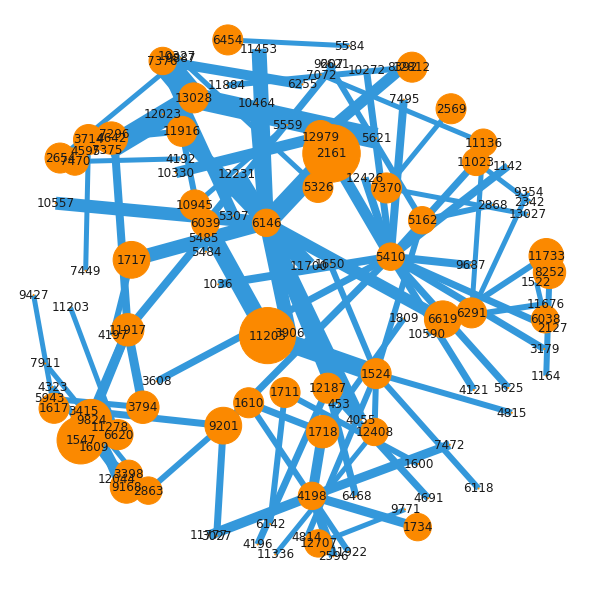

Resulting graph contains
- coauthor_nodes:  4262
- coauthor_edges:  3708

       Initial selected Authors


,author-index,author-name,number-papers
0,0,"(Bert) Hakkinen, Pertti J",1
1,1,"A, Balram",1
2,2,"A, Chudnovsky",1
3,3,"A, Erickson",6
4,4,"A, Gasparrini",1
...,...,...,...
13063,13063,"van den Hazel, Peter",1
13077,13077,"vanNetten, C",2
13078,13078,"vanNetten, C.",1
13088,13088,"yang, Allen y.",1


In [78]:
#--------------------------------------------------------------------------
# Visualise Co-Authors of Published Papers linked by Author ID (unique Name)
# Basic graph version to help understand data, not interactive
# colours: https://htmlcolorcodes.com/
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

clr_edge = '#3498DB'
clr_node = '#FB8900'

G = nx.Graph()  

# check data
# print('df_pairs:', df_pairs.head(5),'\n\nlen(df_pairs) =',len(df_pairs))
df_pairs_sample = df_pairs[0:sample_rows]

i=0
for index, row in df_pairs_sample.iterrows():
    #G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    G.add_node(row['author-1'], nodesize=row['weight']*30)
    i=i+1

widths = []
for index, row in df_pairs_sample.iterrows():
    G.add_weighted_edges_from([(row['author-1'], row['author-2'], row['weight'])])
    widths.append(row['weight'])
    #G.add_edges_from([(row['author-1'], row['author-2'])])

# approx 5 mins to run this far
print('node rows     =',i)

plt.figure(figsize=(8,8))
options = {
    'edge_color': clr_edge,
    'node_color': clr_node,
    'with_labels': True,
    'font_weight': 'regular',
}

node_weight = 5
#colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
sizes = [G.nodes[n]['nodesize']*node_weight if len(G.nodes[n].keys())>0 else 1 for n in G]
# print(widths)

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
- default k=0.1 and iterations=50

nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
"""

nx.draw(G, node_size=sizes, width=widths, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor(clr_node) 
plt.show();

# only show time taken if over 1 min
if (timeit.default_timer() - starttime)>60:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print('Resulting graph contains')
print('- coauthor_nodes: ', len(node_pairs))
print('- coauthor_edges: ', len(df_pairs))

nodes = df_node_author[['node_id','node_name','size_author']].copy()
nodes.columns = ['author-index','author-name','number-papers']
print('\n       Initial selected Authors')
nodes[nodes['author-index'].isin(select_author_index)]